In [1]:
!pip install prettytable


In [2]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchsummary import summary
import numpy as np

In [3]:
PATH_HAZE="data/"

In [4]:
PATH=PATH_HAZE

In [5]:
BATCH_SIZE=4
image_shape=(3,256,256)

In [6]:
image_shape[0]

3

In [7]:
def load_image(image_path):
    preporocess=transforms.Compose([
        transforms.Resize(image_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0,0,0],std=[1,1,1])
    ])
    img=Image.open(image_path)
    img=preporocess(img)
    return img
def load_paired_data(real_img_path, fake_img_path):
    real_img=load_image(real_img_path)
    fake_img=load_image(fake_img_path)
    return real_img, fake_img

In [8]:
class CustomDataset(Dataset):
    def __init__(self ,path ,transform=None):
        self.haze_img_path = [os.path.join(path,'input',item) for item in sorted(os.listdir(os.path.join(path, "input")))]
        self.clear_img_path=[os.path.join(path,'target',item) for item in sorted(os.listdir(os.path.join(path,'target')))]
        self.transform=transform
    def __len__(self):
        return len(self.haze_img_path)
    def __getitem__(self,idx):
        haze_img=Image.open(self.haze_img_path[idx])
        clear_img=Image.open(self.clear_img_path[idx])
        if self.transform:
            haze_img=self.transform(haze_img)
            clear_img=self.transform(clear_img)
            return haze_img, clear_img
def load_dataset(PATH,test_ds=False,batch_size=4):
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0,0,0], std=[1,1,1])
    ])       
    dataset=CustomDataset(PATH,transform=transform)
    if test_ds:
        dataloader = DataLoader(dataset , batch_size=1, shuffle=False)
    else :
        dataloader= DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True)
    return dataloader    

In [9]:
train_ds = load_dataset(PATH + 'train/')
print(len(train_ds))

225


In [10]:
moderate_test_ds = load_dataset(PATH + 'test_moderate/', test_ds=True)
thick_test_ds = load_dataset(PATH + 'test_thick/', test_ds=True)
thin_test_ds = load_dataset(PATH + 'test_thin/', test_ds=True)

In [11]:
print(len(moderate_test_ds))

45


# Visualizing Dataset

In [12]:
def subplot(img1, img2, title1, title2):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(img1.permute(1, 2, 0))
    axes[0].set_title('Haze Image')
    axes[0].axis('off')
    axes[1].imshow(img2.permute(1, 2, 0))
    axes[1].set_title('Clear Image')
    axes[1].axis('off')
    plt.show()

torch.Size([4, 3, 512, 512])


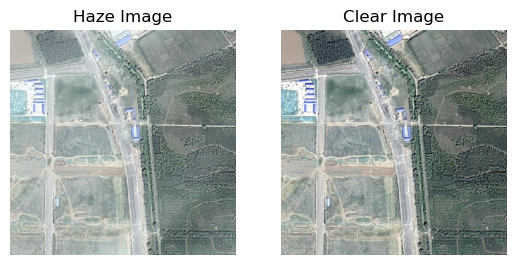

In [13]:
haze_image, clear_image = next(iter(train_ds))
print(haze_image.shape)
subplot(haze_image[0], clear_image[0], 'Haze Image', 'Clear Image')

# MODEL

In [14]:
import torch.nn as nn

In [23]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, f, pooling=True):
        super(InceptionBlock, self).__init__()
        self.f = f
        self.pooling = pooling
        
        '''===PATH1==='''
        self.conva0 = nn.Conv2d(in_channels, self.f, kernel_size=(1, 1), padding=(0, 0))  # Adjust padding here
        self.batch_norma0 = nn.BatchNorm2d(self.f)
        self.conva1 = nn.Conv2d(self.f, self.f, kernel_size=(3, 3), padding=(1, 1))
        self.batch_norma1 = nn.BatchNorm2d(self.f)
        self.conva2 = nn.Conv2d(self.f, self.f, kernel_size=(1, 3), padding=(0, 1))  # Adjust padding here
        self.batch_norma2 = nn.BatchNorm2d(self.f)
        self.conva3 = nn.Conv2d(self.f, self.f, kernel_size=(3, 1), padding=(1, 0))  # Adjust padding here
        self.batch_norma3 = nn.BatchNorm2d(self.f)
        self.concat1 = nn.ModuleList([self.conva0, self.batch_norma0, self.conva1, self.batch_norma1, self.conva2, self.batch_norma2, self.conva3, self.batch_norma3])
        self.poola = nn.MaxPool2d(kernel_size=(2, 2))    
        '''===PATH2==='''
        self.convb0 = nn.Conv2d(in_channels, self.f, kernel_size=(1, 1), padding=(0, 0))  # Adjust padding here
        self.batch_normb0 = nn.BatchNorm2d(self.f)
        self.convb1 = nn.Conv2d(self.f, self.f, kernel_size=(1, 3), padding=(0, 1))  # Adjust padding here
        self.batch_normb1 = nn.BatchNorm2d(self.f)
        self.convb2 = nn.Conv2d(self.f, self.f, kernel_size=(3, 1), padding=(1, 0))  # Adjust padding here
        self.batch_normb2 = nn.BatchNorm2d(self.f)
        self.concat2 = nn.ModuleList([self.convb0, self.batch_normb0, self.convb1, self.batch_normb1, self.convb2, self.batch_normb2])
        self.poolb = nn.MaxPool2d(kernel_size=(2, 2))
        
        '''===PATH3==='''
        self.ppoolc = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.convc0 = nn.Conv2d(in_channels, self.f, kernel_size=(1, 1), padding=(0, 0))  # Adjust padding here
        self.batch_normc0 = nn.BatchNorm2d(self.f)
        self.poolc = nn.MaxPool2d(kernel_size=(2, 2))
        
        '''===PATH4==='''
        self.convd1 = nn.Conv2d(in_channels, self.f, kernel_size=(1, 1), padding=(0, 0))  # Adjust padding here
        self.batch_normd1 = nn.BatchNorm2d(self.f)
        self.poold = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.concat = nn.ModuleList([self.convc0, self.batch_normc0, self.convd1, self.batch_normd1])
    
    def forward(self, inputs):
        conva = self.conva0(inputs)  # 1x1
        conva = self.batch_norma0(conva)
        conva = self.conva1(conva)   # 3x3
        conva = self.batch_norma1(conva)
        conva_con1 = self.conva2(conva)  # 1x3
        conva_con1 = self.batch_norma2(conva_con1)
        conva_con2 = self.conva3(conva)  # 3x1
        conva_con2 = self.batch_norma3(conva_con2)
        conva = torch.cat([conva_con1, conva_con2], dim=1)
        if self.pooling:
            conva = self.poola(conva)
            
        convb = self.convb0(inputs)  # 1x1
        convb = self.batch_normb0(convb)
        convb_con1 = self.convb1(convb)  # 1x3
        convb_con1 = self.batch_normb1(convb_con1)
        convb_con2 = self.convb2(convb)  # 3x1
        convb_con2 = self.batch_normb2(convb_con2)
        convb = torch.cat([convb_con1, convb_con2], dim=1)
        if self.pooling:
            convb = self.poolb(convb)
            
        convc = self.ppoolc(inputs)
        convc = self.convc0(convc)
        convc = self.batch_normc0(convc)
        if self.pooling:
            convc = self.poolc(convc)
            
        convd = self.convd1(inputs)
        convd = self.batch_normd1(convd)
        if self.pooling:
            convd = self.poold(convd)
            
        up = torch.cat([conva, convb, convc, convd], dim=1)
        return up


In [29]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=(1,1))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1,1))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1,1))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv7 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1,1))
        self.conv8 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1,1))
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv9 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1,1))
        self.conv10 = nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1))

        self.i1 = InceptionBlock(768, 128, False)  # Adjust input channels here
        self.i2 = InceptionBlock(256, 128, True)  # Adjust input channels here
        self.i3 = InceptionBlock(256, 128, True)   # Adjust input channels here
        self.i4 = InceptionBlock(256, 128, True) 

        self.up6 = nn.Upsample(scale_factor=2)
        self.conv11 = nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1,1))
        self.conv12 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1,1))

        self.up7 = nn.Upsample(scale_factor=2)
        self.conv13 = nn.Conv2d(256, 128, kernel_size=(3, 3), padding=(1,1))
        self.conv14 = nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1,1))

        self.up8 = nn.Upsample(scale_factor=2)
        self.conv15 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1,1))
        self.conv16 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1,1))

        self.up9 = nn.Upsample(scale_factor=2)
        self.conv17 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding=(1,1))
        self.conv18 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=(1,1))

        self.conv19 = nn.Conv2d(32, 3, kernel_size=(1, 1))
        
        self.convT1 = nn.ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2), padding=(1,1))
        self.convT2 = nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1,1))
        self.convT3 = nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1,1))
        self.convT4 = nn.ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1,1))

    def forward(self, batch):
        conv1 = nn.functional.relu(self.conv1(batch))
        conv1 = nn.functional.relu(self.conv2(conv1))
        pool1 = self.pool1(conv1)

        conv2 = nn.functional.relu(self.conv3(pool1))
        conv2 = nn.functional.relu(self.conv4(conv2))
        pool2 = self.pool2(conv2)

        conv3 = nn.functional.relu(self.conv5(pool2))
        conv3 = nn.functional.relu(self.conv6(conv3))
        pool3 = self.pool3(conv3)
        
        conv4 = nn.functional.relu(self.conv7(pool3))
        conv4 = nn.functional.relu(self.conv8(conv4))
        pool4 = self.pool4(conv4)

        conv5 = nn.functional.relu(self.conv9(pool4))
        conv5 = nn.functional.relu(self.conv10(conv5))
        batch_processed = batch[:, :3, :, :]
        i1 = self.i1(batch_processed)
        print(i1.shape)
        i2 = self.i2(i1)
        i3 = self.i3(i2)
        i4 = self.i4(i3)

        up6 = torch.cat([self.convT1(conv5), conv4, i4], dim=1)
        conv6 = nn.functional.relu(self.conv11(up6))
        conv6 = nn.functional.relu(self.conv12(conv6))

        up7 = torch.cat([self.convT2(conv6), conv3, i3], dim=1)
        conv7 = nn.functional.relu(self.conv13(up7))
        conv7 = nn.functional.relu(self.conv14(conv7))

        up8 = torch.cat([self.convT3(conv7), conv2, i2], dim=1)
        conv8 = nn.functional.relu(self.conv15(up8))
        conv8 = nn.functional.relu(self.conv16(conv8))

        up9 = torch.cat([self.convT4(conv8), conv1, i1], dim=1)
        conv9 = nn.functional.relu(self.conv17(up9))
        conv9 = nn.functional.relu(self.conv18(conv9))

        conv10 = torch.tanh(self.conv19(conv9))
        return conv10


In [30]:
generator = Generator().to('cuda')  # Move model to CUDA
print(generator)


Generator(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, 

In [31]:
from prettytable import PrettyTable

# Create a table
table = PrettyTable(["Layer", "Input Shape", "Output Shape", "Param #"])
total_params = 0

# Iterate over the layers
for name, param in generator.named_parameters():
    if param.requires_grad:
        layer_name = name.split('.')[0]
        input_shape = list(param.shape)
        output_shape = None
        if 'conv' in layer_name:
            output_shape = list(generator.state_dict()[name].shape)
        else:
            continue
        param_count = param.numel()
        total_params += param_count
        table.add_row([layer_name, input_shape, output_shape, param_count])

# Print the table
print(table)
print(f"Total Trainable Parameters: {total_params}")


+--------+------------------+------------------+---------+
| Layer  |   Input Shape    |   Output Shape   | Param # |
+--------+------------------+------------------+---------+
| conv1  |  [32, 3, 3, 3]   |  [32, 3, 3, 3]   |   864   |
| conv1  |       [32]       |       [32]       |    32   |
| conv2  |  [32, 32, 3, 3]  |  [32, 32, 3, 3]  |   9216  |
| conv2  |       [32]       |       [32]       |    32   |
| conv3  |  [64, 32, 3, 3]  |  [64, 32, 3, 3]  |  18432  |
| conv3  |       [64]       |       [64]       |    64   |
| conv4  |  [64, 64, 3, 3]  |  [64, 64, 3, 3]  |  36864  |
| conv4  |       [64]       |       [64]       |    64   |
| conv5  | [128, 64, 3, 3]  | [128, 64, 3, 3]  |  73728  |
| conv5  |      [128]       |      [128]       |   128   |
| conv6  | [128, 128, 3, 3] | [128, 128, 3, 3] |  147456 |
| conv6  |      [128]       |      [128]       |   128   |
| conv7  | [256, 128, 3, 3] | [256, 128, 3, 3] |  294912 |
| conv7  |      [256]       |      [256]       |   256  

In [32]:
haze_image = haze_image.to('cuda')
gen_output = generator(haze_image)

subplot(haze_image, gen_output, 'Haze Image', 'Generated')

RuntimeError: Given groups=1, weight of size [128, 768, 1, 1], expected input[4, 3, 512, 512] to have 768 channels, but got 3 channels instead

In [28]:
torch.cuda.empty_cache()